# Imports

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from sklearn import metrics
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm  import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
df = pd.read_csv('train.csv')

In [116]:
df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.72124,0.749280,...,-4.40,6,9.76,-21.82,49.18,1.0435,-0.9066,1.5883,3.4154,2.8283,2.3451,0.030594,1.7418,1.5271,0.8474,0.4715,0.028362,3.1611,2.5162,2.0037,0.019636,4.4352,4.2676,-0.1524,1,-0.40,-0.560,-0.440,-0.6280,-3.14,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,0.6903,0.6903,8.449459e+08,78,50,754416.0,78.0,78.0,78.00,78.00,78.0,0.8478,0,0,0,6,0,0,0.65705,0.64069,0.626200,...,0.35,7,51.73,-72.44,798.74,2.7180,-0.8294,1.0740,2.9194,2.1180,1.5666,0.120442,1.1963,1.0322,0.4843,0.2389,0.130160,2.7659,1.9523,1.4059,0.115277,3.2763,2.7962,-0.3097,1,-0.17,-0.275,-0.203,-0.2300,-1.38,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,126.49,7,0.7542,0.7542,1385872,0.7542,0.7542,0.5508,0.7542,0.8091,0.7807,1.308478e+09,89,54,1037651.0,89.0,89.0,100.43,94.37,89.0,0.9175,0,0,0,13,0,0,0.74710,0.75878,0.654685,...,-6.35,14,56.62,-79.48,621.97,1.9592,-0.3632,3.2969,7.2072,5.7062,4.5627,0.226336,3.3277,3.4166,1.8321,0.9979,0.103307,6.8623,5.2963,4.1282,0.219729,8.1381,7.3269,-0.1909,1,-0.58,-0.540,-0.572,-0.3985,-5.18,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,133.58,7,0.8017,0.7881,704687,0.7881,0.7881,0.5923,0.7881,0.8230,0.8158,1.472752e+09,93,55,1115721.0,93.0,93.0,114.63,102.92,93.0,0.9688,0,0,0,4,0,0,0.77405,0.78929,0.750675,...,3.75,5,36.31,18.15,429.81,2.5883,-0.8812,1.2950,2.5777,2.0830,1.6899,0.054630,1.3748,1.3421,0.7982,0.4810,0.081205,2.5571,2.0593,1.6653,0.056470,3.2516,3.0631,-0.1770,1,-0.75,-0.635,-0.745,-0.5100,-2.04,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,112.77,6,0.5263,0.5263,51985,0.5263,0.5263,0.3044,0.5405,0.5556,0.5455,1.442916e+09,60,21,536400.0,60.0,60.0,60.00,60.00,60.0,0.8451,0,0,0,26,0,0,0.60315,0.53367,0.696150,...,11.45,27,2206.14,-10559.05,708436.49,9.0293,-0.8760,6.3852,17.2599,14.2795,11.9179,0.085330,7.2175,6.2262,3.1446,1.6149,0.074286,15.9080,12.5688,9.9844,0.067540,17.5561,15.6079,-0.4444,1,-0.18,-0.280,-0.182,-0.4277,-11.12,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [117]:
df.shape

(105471, 771)

In [118]:
df.columns

Index(['id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778',
       'loss'],
      dtype='object', length=771)

# Data Wrangling: Cleansing and Feature Selection

In [119]:
df['loss'].unique()

array([  0,   1,  16,  19,   4,  11,  21,   2,   9,   5,   3,   7,  13,
         6,  25,  44,  17, 100,  10,   8,  65,  15,  12,  29,  22,  20,
        18,  41,  55,  28,  23,  14,  38,  42,  33,  27,  24,  39,  26,
        31,  35,  64,  32,  54,  37,  61,  79,  51,  43,  77,  47,  36,
        46,  81,  78,  60,  45,  85,  84,  34,  90,  40,  50,  92,  74,
        62,  53,  59,  89,  48,  30,  49,  99,  73,  95,  83,  56,  70,
        71,  68,  94,  72,  57,  58,  52,  63,  69,  76,  80])

In [120]:
default_criteria = 0
df['default'] = df['loss'].apply(lambda x: 1 if x > default_criteria else 0)
df['default'].unique()

array([0, 1])

In [121]:
#check if the data is imbalanced
df['default'].sum()/len(df['default'])

0.09275535455243622

It's quite small number, so data is imbalanced. Let's visualize to see unbalanced data clearly

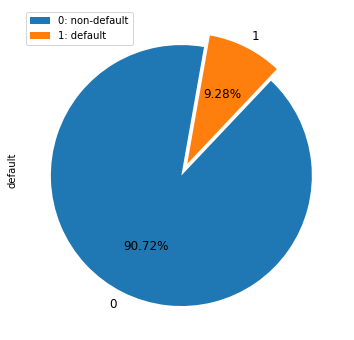

In [122]:
df['default'].value_counts().plot(kind='pie', 
                                  autopct='%1.2f%%', 
                                  explode= (0.05, 0.05), 
                                  startangle=80, legend=True, 
                                  fontsize=12, figsize=(14,6))
plt.legend(["0: non-default","1: default"])

There are more non-default cases than default ones. We should try to get balanced dataset. For this, we should sample random indexes for non default dataset and drop them.

In [123]:
sum_non_defaults = df.loc[df['default']==0].shape[0]
sum_non_defaults

95688

In [124]:
sum_defaults = df.loc[df['default']==1].shape[0]
sum_defaults

9783

In [125]:
diff = 1 - sum_defaults/sum_non_defaults
not_default = np.array(df.loc[df['default']==0].index)
random_drops = np.random.choice(not_default,int(diff*len(not_default)), replace = False)
random_drops.size

85905

In [126]:
#Now let's drop those random indices and check data imbalance 
df = df.drop(index=random_drops,axis = 0).reset_index()
df['default'].sum()/len(df['default'])

0.5

In [127]:
y = df[['default']]
x= df.drop(columns=['default','loss','id'],axis = 1)

In [128]:
y.head()

,default
0,1
1,0
2,0
3,1
4,0


In [129]:
y.shape

(19566, 1)

In [130]:
x.head()

,index,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,...,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,7,128,9,0.385778,2900,4,79244,6597.0,3592.0,127.19,127.89,6,0.8596,0.7967,17175731,0.8033,0.7538,0.5868,0.8376,0.9159,0.8522,3.127331e+09,98,75,1219708.0,98.0,98.0,120.79,108.46,98.0,0.9899,0,0,0,17,0,0,0.72690,0.73842,0.739165,...,1.1939,21.49,18,177.11,361.87,5280.10,2.9007,-0.7834,5.5179,11.5597,9.6605,8.1316,0.082056,6.0522,5.1945,3.0525,1.8459,0.120041,10.7886,8.7296,7.1231,0.084859,13.8244,13.0117,-0.0841,1,-0.71,-0.475,-0.649,-0.4182,-7.11,17,4.45,-3.26,2.56,0.2947,-0.7220,0,0,5
1,8,126,9,0.745471,2900,4,78920,3058.0,112.0,123.89,125.53,6,0.8684,0.8049,1560191,0.8115,0.7615,0.5705,0.8462,0.9252,0.8609,3.040701e+09,99,72,1185921.0,99.0,99.0,122.03,109.56,99.0,1.0000,0,0,0,7,0,0,0.76075,0.76535,0.657429,...,1.2175,9.74,8,45.34,98.11,422.89,2.0458,-0.8261,2.1964,4.5327,3.9902,3.5362,0.312681,2.5327,2.2290,1.3060,0.7808,0.093893,4.2704,3.6432,3.1261,0.302410,5.2912,5.0922,-0.0748,1,-0.86,-0.660,-0.814,-0.4700,-3.29,7,2.02,-1.35,0.95,0.2601,0.7132,0,0,5
2,11,120,9,0.801255,1300,3,13026,4566.0,982.0,118.14,119.56,14,0.7177,0.7177,0,0.7236,0.7177,0.4852,0.7236,0.8018,0.7946,1.407657e+09,89,37,918836.0,89.0,89.0,89.00,89.00,89.0,0.8641,0,0,0,90,0,0,0.74885,0.72593,0.799627,...,-0.5743,-52.26,91,4109.98,-12084.18,500556.49,6.6959,-0.5692,38.7461,64.6477,56.1763,49.1775,0.086327,39.7509,35.1756,22.9261,15.2278,0.113995,62.8947,53.2318,45.3576,0.079692,72.3169,68.0206,-0.1982,1,-0.27,-0.295,-0.263,-0.4994,-44.95,90,30.95,-23.64,18.93,0.3073,0.4915,0,0,5
3,16,130,9,0.437883,1300,3,11255,3679.0,2969.0,129.74,130.00,14,0.9292,0.8974,1452127,0.8537,0.8468,0.7569,0.9211,0.9459,0.9211,2.207205e+09,105,77,1433250.0,105.0,105.0,138.75,120.19,105.0,0.9459,0,0,0,54,0,0,0.80340,0.83212,0.813783,...,1.1065,60.86,55,2047.45,2269.90,227675.97,6.0002,-0.7169,25.9252,41.2324,36.7683,32.9873,0.141878,27.6148,24.7630,17.2124,12.1137,0.097355,39.3422,34.2219,29.9280,0.135889,44.2577,42.0351,-0.0541,1,-0.14,-0.220,-0.136,-0.5319,-28.72,54,19.33,-14.17,10.84,0.2740,0.7246,0,0,5
4,17,125,9,0.681169,1300,3,14184,332.0,1528.0,121.88,124.16,14,0.8319,0.8049,259490,0.8049,0.8049,0.5890,0.8049,0.9000,0.8534,1.250608e+09,99,70,1136916.0,99.0,99.0,99.00,99.00,99.0,0.9340,0,0,0,62,0,0,0.82245,0.80441,0.813179,...,-0.4008,-25.25,63,1974.53,925.27,164975.80,5.5840,0.6695,28.3608,47.0877,41.4841,36.7511,0.079540,29.8027,24.8362,16.2556,10.8080,0.104248,45.2644,39.0584,33.8705,0.074342,51.4802,48.8033,-0.1000,1,-0.50,-0.500,-0.510,-0.5239,-32.48,62,22.33,-16.97,13.52,0.2928,0.5747,0,0,5


In [131]:
x.shape

(19566, 770)

In [132]:
#as we see there a 770 columns in x data. So let's reduce them
new_x_columns = np.random.choice(x.columns, 100, replace = False)
x = x[new_x_columns]
x.shape

(19566, 100)

In [134]:
x.describe()

,f659,f113,f340,f223,f119,f452,f520,f740,f334,f102,f343,f431,f675,f580,f727,f363,f124,f540,f28,f562,f483,f416,f327,f100,f413,f515,f680,f181,f411,f173,f257,f351,f494,f752,f481,f355,f714,f709,f397,f701,...,f427,f274,f160,f559,f362,f576,f455,f109,f628,f567,f442,f266,f55,f399,f500,f551,f544,f374,f541,f757,f294,f732,f165,f180,f461,f729,f72,f86,f339,f682,f696,f447,f259,f512,f641,f217,f557,f152,f258,f246
count,1.956600e+04,19522.000000,17998.00000,19549.000000,19544.000000,19522.000000,19566.000000,19566.000000,19566.000000,19522.000000,19566.000000,19566.000000,19566.000000,1.954900e+04,19566.000000,1.956600e+04,19544.000000,19549.000000,19566.000000,1.954900e+04,19522.000000,19566.000000,19566.000000,19316.000000,19524.000000,19566.000000,19566.000000,19110.000000,19566.000000,19342.000000,19549.000000,19566.000000,19522.000000,19566.000000,19544.000000,1.956600e+04,19538.000000,19566.000000,19566.000000,19566.0,...,19566.000000,1.954900e+04,16385.000000,19537.000000,19566.000000,1.954900e+04,1.954400e+04,19544.000000,1.945300e+04,1.954900e+04,19543.000000,19549.000000,19557.000000,19280.000000,1.954400e+04,1.954900e+04,1.954900e+04,19428.000000,1.954900e+04,19426.000000,19566.000000,1.956600e+04,19342.000000,16587.000000,1.954400e+04,19566.000000,17970.000000,19544.000000,19566.000000,19566.000000,19557.000000,19566.000000,19472.000000,1.954400e+04,19557.000000,1.954900e+04,1.954900e+04,19110.000000,19549.000000,19549.000000
mean,2.394674e+10,0.212282,1.06215,0.102125,0.386326,352.535174,96260.918133,6.831434,1304.402450,0.109992,94.987342,1.117674,5.409792,1.989595e+06,134.379727,2.586102e+07,0.288844,84.826598,89.270627,2.875239e+08,685.182795,10858.335487,6.026577,1.408345,1.111042,0.005206,63.223866,0.236863,3.207459,0.101654,569.743721,88.092944,332.738843,6.007814,490.280197,1.520890e+09,13.526975,7.458229,0.086863,0.0,...,16.838751,4.126955e+06,1.674382,262.249302,16.838751,3.259909e+15,9.741866e+05,0.288592,6.907657e+08,1.379380e+14,5.827722,831.843828,0.520382,0.084590,2.896224e+11,6.618518e+05,2.773257e+11,-0.507429,7.048831e+05,10.330170,2.064091,5.964907e+09,33.386413,1.682872,5.948512e+14,17.838751,0.976086,352.241046,1927.067268,53.660315,0.234678,2891.874936,1.152716,1.291798e+14,0.714022,3.602384e+07,1.817734e+14,0.120255,0.389853,262.100107
std,9.809922e+10,0.371951,0.45311,0.044826,0.055590,377.274341,81046.595913,36.953901,4667.592972,0.176346,33.627740,0.732390,3.757621,3.582546e+06,13.270615,2.898870e+07,0.078294,89.781941,29.838563,7.888755e+08,689.605665,26078.020401,6.623797,0.093633,0.846821,0.014998,48.031313,0.263122,3.669742,0.083185,587.711094,20.818054,316.439284,7.866863,477.031370,1.773390e+09,15.321866,9.471753,0.115809,0.0,...,17.835547,6.936632e+06,0.326828,254.445876,17.835547,1.267128e+16,1.479695e+06,0.040203,5.361980e+08,5.829162e+14,1.279376,837.311637,0.134329,0.115396,7.026765e+11,1.206267e+06,9.032201e+11,0.849953,1.262121e+06,12.422991,2.501782,5.765699e+09,115.588308,0.256575,3.135131e+15,17.835547,6.796013,377.274180,7892.621595,37.493724,0.075018,2377.802201,0.156769,3.015856e+14,0.209142,4.274167e+07,7.524504e+14,0.296344,0.058082,254.451502
min,6.410000e+02,0.000000,-1.08000,0.000000,0.000000,0.000000,12.530000,-406.110000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,110.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-20.539130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,...,2.000000,0.000000e+00,0.990000,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.385000,0.000000,0.018000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-33.550010,0.000000e+00,0.000000,0.000000,4.722063e+08,0.000000,1.000000,0.000000e+00,3.000000,-1.000000,0.000000,0.000000,3.500000,0.000000,1.000000,-0.880000,0.000000e+00,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,4.024746e+08,0.000000,0.99000,0.070000,0.36

In [135]:
x.isnull().sum()

f659       0
f113      44
f340    1568
f223      17
f119      22
        ... 
f217      17
f557      17
f152     456
f258      17
f246      17
Length: 100, dtype: int64

In [136]:
sum_nulls = x.isnull().sum().sum()
sum_nulls

14335

It seems many columns have missing values. But which ones have most? We can find and remove them with the help of their percentage of missing values 

In [137]:
nulls = np.around((x.isnull().sum()/len(x))*100,2)
null_rates_df = pd.DataFrame(data = nulls.values, columns = ['null_rate'],index = nulls.index)
null_rates_df

,null_rate
f659,0.00
f113,0.22
f340,8.01
f223,0.09
f119,0.11
...,...
f217,0.09
f557,0.09
f152,2.33
f258,0.09


In [138]:
null_rates_df['null_rate'].values

array([ 0.  ,  0.22,  8.01,  0.09,  0.11,  0.22,  0.  ,  0.  ,  0.  ,
        0.22,  0.  ,  0.  ,  0.  ,  0.09,  0.  ,  0.  ,  0.11,  0.09,
        0.  ,  0.09,  0.22,  0.  ,  0.  ,  1.28,  0.21,  0.  ,  0.  ,
        2.33,  0.  ,  1.14,  0.09,  0.09,  0.  ,  0.22,  0.  ,  0.11,
        0.  ,  0.  ,  0.14,  0.  ,  0.  ,  0.  ,  1.14,  0.15,  0.  ,
        0.15,  1.93,  1.3 ,  0.  ,  0.  ,  0.79,  0.05,  0.22,  0.22,
        0.84,  0.14,  1.14,  0.72,  0.16,  0.  ,  0.09, 16.26,  0.15,
        0.  ,  0.09,  0.11,  0.11,  0.58,  0.09,  0.12,  0.09,  0.05,
        1.46,  0.11,  0.11,  0.09,  0.09,  0.71,  0.09,  0.72,  0.  ,
        0.  ,  1.14, 15.23,  0.11,  0.  ,  8.16,  0.11,  0.  ,  0.  ,
        0.05,  0.  ,  0.48,  0.11,  0.05,  0.09,  0.09,  2.33,  0.09,
        0.09])

In [139]:
# We can drop columnns with percentage of missing values more than 10% which is likely to yield good results.
droping_columns = list(null_rates_df.loc[null_rates_df['null_rate'] > 10].index.values)
x.drop(columns = droping_columns, axis = 1, inplace = True)
sum_nulls_new = x.isnull().sum().sum()
#Sum of null values decreased from
print('Sum of null values decreased from ',sum_nulls, 'to ', sum_nulls_new)

Sum of null values decreased from  14335 to  8175


In [140]:
# Now, let's identify columns with object dtype
x_objects = x.select_dtypes(include='object')
x_objects

,f277,f419,f534,f138
0,3620246973781699985408,13100000000000,303031648189360025632768,18874963171119999221760
1,1600000000000000,65835981675,2910000000000000,756000000000000000
2,7050000000000000000,35200000000000000,263557268554800005120,5930000000000000000
3,28103208518627999744,6520000000000000,8182702240508799877120,236595025954309996544
4,69200000000000000,2250000000000000,116339444441779994624,16000000000000000
...,...,...,...,...
19561,8167628291968600113152,71317466325,30050637795516999951974400,326013046331269971968
19562,11365724246755000320,1290000000000,3128728593098900242432,372206257024050003968
19563,558741905759400030633984,27600000000000,22643797124327001825476608,299123102688960015499264
19564,3505717612445999969599488,113000000000,4997826307025199716892672,18627949861009000235008


In [141]:
x.drop(columns = x_objects.columns, axis = 1, inplace = True)
x.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

# Investigating cardinality

In [142]:
zero_variance_columns = []
numeric_columns = []
ordinal_columns = []
nominal_columns = []
category = []
for col in x.columns:
  if x[col].nunique() == 1:
    category.append('zero_variance')
    zero_variance_columns.append(col)
  elif x[col].nunique() <= 3:
    category.append('nominal')
    nominal_columns.append(col)
  elif x[col].nunique() <= 10:
    category.append('ordinal')
    ordinal_columns.append(col)
  else:
    numeric_columns.append(col)
    category.append('numeric')

categories = pd.DataFrame(data = category, columns = ['category'], index = x.columns)
categories.head()

,category
f659,numeric
f113,ordinal
f340,numeric
f223,numeric
f119,numeric


Its underlying idea is that if a feature is constant (i.e. it has 0 variance), then it cannot be used for finding any interesting patterns and can be removed from the dataset.

In [143]:
zero_variance_cols = list(filter(lambda col: (x[col].nunique() == 1), x))
#or
# zero_variance_cols = [col for col in x.columns if x[col].nunique() == 1]

In [144]:
x.drop(columns = zero_variance_cols,axis = 1, inplace = True)

# Data Preprocessing (Pipelines)

We typically will only one-hot encode columns with relatively low cardinality."Cardinality" means the number of unique values in a column.

Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding. 

So we will create a one-hot encoding for columns with cardinality less than 3, ordinal encoder for columns cardinality less than 10

In [145]:
pipeline_ordinal = Pipeline(steps=[
                                   ('imputer',SimpleImputer(strategy = 'median')),
                                   ('encoder', OrdinalEncoder())
])

In [146]:
pipeline_nominal = Pipeline(steps=[
                                   ('imputer', SimpleImputer(strategy = 'most_frequent')),
                                    ('encoder', OneHotEncoder(handle_unknown = 'ignore',sparse = False))
])

In [147]:
pipeline_numeric = Pipeline(steps = [
                                     ('imputer',SimpleImputer(strategy = 'mean')),
                                     ('scaler',StandardScaler())
])

In [148]:
preprocessor = ColumnTransformer(transformers = [
                                                 ('ordinal', pipeline_ordinal, ordinal_columns),
                                                 ('nominal', pipeline_nominal, nominal_columns),
                                                 ('numeric', pipeline_numeric, numeric_columns)
])

# Future Selection

In [149]:
future_pipeline = Pipeline(steps = [
                                    ('preprocessor', preprocessor),
                                    ('selector', SelectKBest(mutual_info_classif, k = 20))
])

In [150]:
x = future_pipeline.fit_transform(x,y.values.ravel())

# Choosing Best Model

In [151]:
X_train, X_test, y_train, y_test = train_test_split(x,y.values.ravel(),test_size = 0.2, shuffle = True)

In [153]:
class_model = []
class_model.append(('SVM:', SVC()))
class_model.append(('Random Forest:', RandomForestClassifier()))
class_model.append(('Logistic Regression', LogisticRegression()))
for name,model in class_model:
  folds = KFold(n_splits = 10)
  results = cross_val_score(model,x,y.values.ravel(), cv = folds, scoring = 'accuracy')
  print('Model', name, 'Accuracy is ', round(results.mean(),3))

Model SVM: Accuracy is  0.608
Model Random Forest: Accuracy is  0.596
Model Logistic Regression Accuracy is  0.606


As it can be shown from results model SVM performs better than others

# Hyper parameter Tuning

In [154]:
# Now let's maximizing a model's performance by hyper parameter tuning
clf = GridSearchCV(SVC(gamma = 'auto'),{
    'C' : [1,10,20],
    'kernel' : ['rbf', 'linear']
}, cv = 5 , return_train_score = False)
clf.fit(x,y.values.ravel())

GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid={'C': [1, 10, 20], 'kernel': ['rbf', 'linear']})

In [155]:
# Adding results to DataFrame
model_result = pd.DataFrame(clf.cv_results_)
model_result[['param_C','param_kernel','mean_test_score']]

,param_C,param_kernel,mean_test_score
0,1,rbf,0.606307
1,1,linear,0.604876
2,10,rbf,0.598027
3,10,linear,0.604774
4,20,rbf,0.593427
5,20,linear,0.604774


In [156]:
clf.best_score_

0.6063071472383305

In [157]:
clf.best_params_

{'C': 1, 'kernel': 'rbf'}

Based on above, we can conclude that SVM with C=1 and kernel='linear' is the best model for solving problem of bank loan default classification

In [158]:
model = SVC(kernel = 'linear', C = 1, gamma = 'auto', probability=True)
model.fit(X_train, y_train)

SVC(C=1, gamma='auto', kernel='linear', probability=True)

In [159]:
# predictions
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 1, 1, 0])

# Assessing Model Performance

In [160]:
print('Classification report of model: \n', classification_report(y_test,predictions))
print('Confusion matrix of model:''\n', confusion_matrix(y_test, predictions),'\n')
print('Roc Score of model:''\n', roc_auc_score(y_test,predictions))

Classification report of model: 
               precision    recall  f1-score   support

           0       0.61      0.58      0.60      1913
           1       0.62      0.65      0.63      2001

    accuracy                           0.62      3914
   macro avg       0.62      0.62      0.62      3914
weighted avg       0.62      0.62      0.62      3914

Confusion matrix of model:
 [[1115  798]
 [ 701 1300]] 

Roc Score of model:
 0.6162646590975291


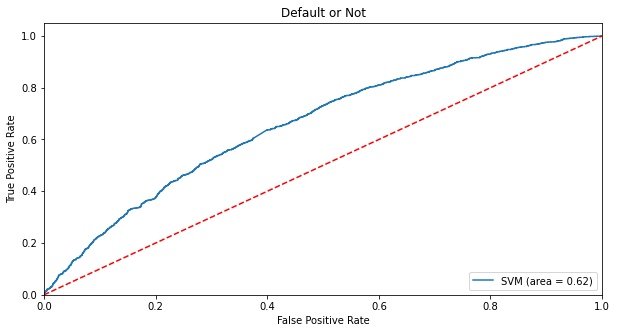

In [161]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Default or Not')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()